# Imaging Tutorial with the Sparse Modeling Technique

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
**PRIISM** is an imaging tool for radio interferometry based on the sparse modeling technique ([PRIISM](https://github.com/tnakazato/priism): Python Module for Radio Interferometry Imaging with Sparse Modeling). 

In this tutorial, we try end-to-end synthesis imaging for ALMA interferometry data using `runner` module with parameter file. For interactive processing using `priism.alma`, please see `tutorial_twhya.ipynb`.

## Setup and Initialize PRIISM

Before you start this tutorial, you should install PRIISM and packages that PRIISM depends on (casatools, casatasks, etc.). Please see README.md on how to install PRIISM. In addition, you need to install `astropy` because this tutorial uses `astropy` to display final image.

There are two fundamental submodules, `priism.core` and `priism.alma`, which are mainly for interactive use. For batch mode, we have `priism.runner` submodule. Here, we demonstrate how to use `runner` submodule as well as show the format of parameter file for `runner`.

We import PRIISM to show the version information. This is not mandatory for the processing purpose.

In [1]:
import priism.alma
print(f'PRIISM version {priism.__version__}')

LOG: initialize sakura...
<module 'priism.external.sakura.libsakurapy' from '/Users/nakazato/pyenv/priism/lib/python3.8/site-packages/priism/external/sakura/libsakurapy.so'>
PRIISM version 0.11.5


We make matplotlib figures to be displayed in the notebook.

In [2]:
%matplotlib inline

## ALMA Data : HL Tau

Sample data for the tutorial is the protoplanetary disk "**HL Tau**" observed at Band 6 with long baselines of ALMA 12m array as part of [science verification](https://almascience.nao.ac.jp/alma-data/science-verification)". The calibration information can be obtained from [CASA Guide](https://casaguides.nrao.edu/index.php?title=ALMA2014_LBC_SVDATA#HL_Tau_-_Protoplanetary_Disk), and the data can be downloaded from the link below: 

https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/HLTau_Band6_CalibratedData.tgz

After you download the data, you should extract the MS from the file. You may run the following cell to obtain the dataset.

In [3]:
%%bash

# download if necessary
[ -e HLTau_Band6_CalibratedData.tgz ] || wget -nv https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/HLTau_Band6_CalibratedData.tgz

# extract data from tar-ball
[ -e HLTau_Band6_CalibratedData ] || tar xf HLTau_Band6_CalibratedData.tgz

## Data Preparation

Since we downloaded calibrated data, input MS is already available at `HLTau_Band6_CalibratedData/HLTau_B6cont.calavg`. Here we just define some variables for convenience. Also, we run `listobs` to get data summary.

In [5]:
import os
from casatasks import listobs

data_dir = 'HLTau_Band6_CalibratedData'
vis = 'HLTau_B6cont.calavg'
listfile = 'HLTau_B6cont.calavg.listobs'
imagename = 'hltau_b6cont_spw0.fits'
    
listobs(vis=f'{data_dir}/{vis}', listfile=listfile, verbose=True, overwrite=True)

os.system(f'grep -E "^Spectral Windows:" -A 5 {listfile}')

....10....20....30....40....50....60....70....80....90....100%


Spectral Windows:  (4 unique spectral windows and 1 unique polarization setups)
  SpwID  Name                           #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz) BBC Num  Corrs  
  0      ALMA_RB_06#BB_1#SW-01#FULL_RES      4   TOPO  224750.000   -500000.000   2000000.0 224000.0000        1  XX  YY
  1      ALMA_RB_06#BB_2#SW-01#FULL_RES      4   TOPO  226750.000   -500000.000   2000000.0 226000.0000        2  XX  YY
  2      ALMA_RB_06#BB_3#SW-01#FULL_RES      4   TOPO  239250.000    500000.000   2000000.0 240000.0000        3  XX  YY
  3      ALMA_RB_06#BB_4#SW-01#FULL_RES      4   TOPO  241250.000    500000.000   2000000.0 242000.0000        4  XX  YY


0

## End-to-end Processing using a Parameter File

Imaging and cross-validation can be processed using parameters stored in a parameter file. PRIISM has `runner` submodule for this purpose. For reading the parameter file, `loadParam` is used. And also, the used parameters can be stored by `saveParam`. You can use `runner` module interactively. In the interactive use case, `runner` submodule saves processing parameters in a parameter file of *.param. (The parameters in cross-validations are automatically stored, such as "cvname.param".) You can manually make the parameter file and apply that for imaging and cross-validation as well.

For example, you can perform imaging or cross-validation using the parameter file "`test.param`" as follows,

```
from priism import runner
hh=runner.Session.loadParam('test.param')
hh.run(overwrite=True)
```

or

```
from priism import runner
hh=runner.Session.loadParam('test.param')
hh.crossValidation(overwrite=True)
```

The sample of the parameter file for the classical cross-validation is given below.

Here, we create the parameter file first. Then we perform end-to-end imaging using `runner` submodule.

First, create the param file.

In [7]:
config = f'''vis:            {data_dir}/{vis}
field:          0
spw:            0
ch:             0~3
datacolumn:     data
imname:         {imagename}
imsize:         [800, 800]
cell:           ['0.005arcsec']
nchan:          1
start:          0
width:          4
cvname:         hltau_b6cont_spw0.cv
solver:         mfista_nufft
l1:             1000000000.0
ltsv:           1000000000.0
maxiter:        100
numFold:        4
imagePolicy:    full
l1List:         [1000.0, 10000.0, 100000.0, 1000000.0]
ltsvList:       [100000000.0, 1000000000.0, 10000000000.0, 100000000000.0]
optimizer:      classical
bayesopt_maxiter:       15
'''

with open('test.param', 'w') as f:
    f.write(config)

Then, feed `test.param` to `runner` submodule.

In [8]:
from priism import runner
hh=runner.Session.loadParam('test.param')
hh.run(overwrite=True)

## Reading parameter file : test.param
#############################
(runner.Session): vis = HLTau_Band6_CalibratedData/HLTau_B6cont.calavg
###### Start PRIISM
***WARN*** refocusing is disabled even if distance to the source is known.


read 8064 visibility chunks


DONE reading visibility chunks
## Image name : hltau_b6cont_spw0.fits
lambda_l1 = 1000000000.0
lambda_tv = 0.0
lambda_tsv = 1000000000.0
c = 5e+10

number of u-v points: 3464751
X-dim of image:       800
Y-dim of image:       800
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.56663e+10
lambda_l1:        1e+09
  L1 cost         0
lambda_tsv:       1e+09
  TSV cost        0
total cost        4.28332e+10

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 100 or Delta_cost < 3.05209e-07

    1 cost = 42833174065.60546, c = 50000000000.00000
   11 cost = 12591386590.56093, c = 19277164471476572.00000
   21 cost = 12227982326.32982, c = 7432181401207171.00000
   31 cost = 12193873026.51490, c = 2865427665058396.00000
   41 cost = 12186124348.97121, c = 4614799908853200.00000
   51 cost = 121

## Display Final Image

The created image is displayed here using the `matplotlib` module.

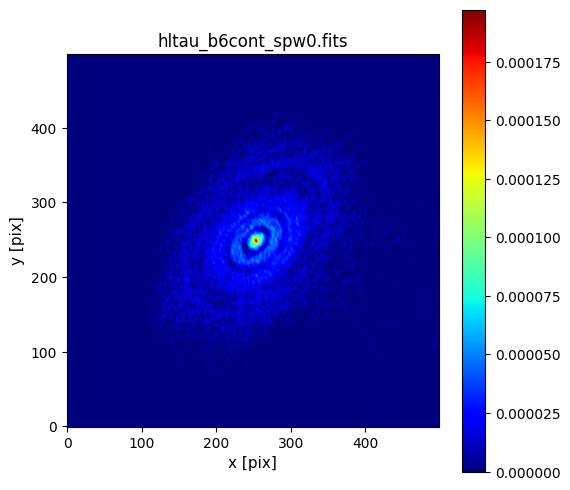

In [9]:
from astropy.io import fits
from matplotlib import pyplot as plt

pixs=800; imwd=500; exwd = (pixs-imwd) // 2
ff,aa=plt.subplots(1,1, figsize=(6,6))
#im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
im=aa.imshow(fits.getdata(imagename)[0,0,exwd+40:((pixs-1)-exwd)+40,exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
#             vmin=0, vmax=0.0005, origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imagename)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(imagename.replace('fits','png'), bbox_inches="tight", pad_inches=0.05)
plt.show()